In [1]:
#| code-summary: code -- load dependencies and data and select parameters
#| echo: false
#| output: false

from compmemlearn.fitting import generate_objective_function, model_weights
from compmemlearn.datasets import events_metadata, generate_trial_mask, simulate_df_from_events
from sentence_transformers import SentenceTransformer, util
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "lightcatCDCATBEH"

data_path = "../../data/CDCATBEH.csv"
results_path = "../../reports/subjectwise_model_evaluation/results/"
figures_path = "figures/"
trial_query = "list_type == 'light'"
embedding_path = '../../data/cdcatmr-cat.npy'
model_paths = [
    "compmemlearn.models.Semantic_CMR",
    "compmemlearn.models.Semantic_CMR"
]

model_names = ["Base_CMR", "Semantic_CMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
        "semantic_scale"
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
        [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
    ],
]
fixed_parameters = [
    {'semantic_scale': 0.0},
    {}
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr', 'compmemlearn.analyses.plot_sem_crp']
analysis_names = ['spc', 'crp', 'pfr', 'semcrp']

experiment_count = 100

In [2]:
#| echo: false
#| output: false

if 'Howard' in section_tag or ('Lohnas' in section_tag and '1' not in section_tag):
    analysis_paths = ['compmemlearn.analyses.plot_flex_spc', 'compmemlearn.analyses.plot_flex_crp', 'compmemlearn.analyses.plot_flex_pfr', 'compmemlearn.analyses.plot_rpl']
    analysis_names = ['spc', 'crp', 'pfr', 'rpl']


print(os.path.abspath(data_path))

c:\Users\gunnj\compmemlearn\data\CDCATBEH.csv


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| echo: false
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations, string_ids = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# load language model and relevant item strings
if embedding_path is not None:
    string_embeddings =  np.load(embedding_path)
else:
    string_embeddings = None

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    extra_mask = generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}')
    subject_specific_trial_mask = [np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
        string_embeddings,
        [string_ids[i][subject_specific_trial_mask[i]] for i in range(len(trials))] if (
            string_ids is not None) else string_ids
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        if string_embeddings is None:
            model = init_model(20, 20, parameters)
        else:
            trial_embeddings = string_embeddings[string_ids[0][0]]
            cosine_scores = util.pytorch_cos_sim(trial_embeddings, trial_embeddings).numpy() + 1
            np.fill_diagonal(cosine_scores, 0)
            model = init_model(cosine_scores, len(string_ids[0][0]), parameters)

        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))

print('dependencies and parameters validated')

<function semantic_objective_function.<locals>.objective_function at 0x000001BF8F2D1D30>
343.29115652917125
1229.5804586588881
<function semantic_objective_function.<locals>.objective_function at 0x000001BF91ED5160>
343.29115652917125
1229.5804586588881
dependencies and parameters validated


In [4]:
#| code-summary: code -- 1) fit each model class participant-by-participant
#| echo: false
#| output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            extra_mask = generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}')
            subject_specific_trial_mask = [
                np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                    string_embeddings,
                    [string_ids[i][subject_specific_trial_mask[i]] for i in range(len(trials))] if (
                        string_ids is not None) else string_ids
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 
                'trial_count': np.sum(
                    [np.sum(subject_specific_trial_mask[i]) for i in range(len(subject_specific_trial_mask))]), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(
                pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

Base_CMR, Subject 1
190.30090446495709
Base_CMR, Subject 2
187.84469519380178
Base_CMR, Subject 3
187.8659036933843
Base_CMR, Subject 5
188.0983834958304
Base_CMR, Subject 6
190.31479271127225
Base_CMR, Subject 7
190.31136588727432
Base_CMR, Subject 8
185.95982768556934
Base_CMR, Subject 9
185.25387225520282
Base_CMR, Subject 10
191.03540697737515
Base_CMR, Subject 11
185.03704262443034
Base_CMR, Subject 12
188.75109934332767
Base_CMR, Subject 13
188.51642179105545
Base_CMR, Subject 14
187.4086536758543
Base_CMR, Subject 15
188.1440763208522
Base_CMR, Subject 16
190.8468946676961
Base_CMR, Subject 17
189.56663431538266
Base_CMR, Subject 18
188.655738843164
Base_CMR, Subject 19
191.03999908694826
Base_CMR, Subject 20
186.4737162459417
Base_CMR, Subject 21


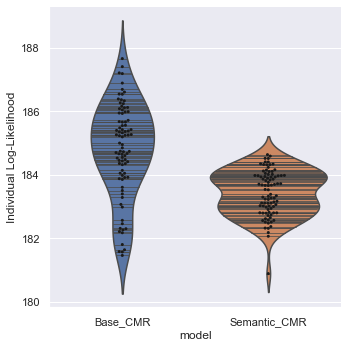

In [ ]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects
#| echo: false

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood');
plt.savefig(figures_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [ ]:
#| echo: false
#| output: false

individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,semantic_scale
0,1,4,185.270128,Base_CMR,0.822563,0.188942,0.791546,0.441518,0.264733,0.807966,1.573845,0.320667,0.008208,0.097842,9.557661,0.399922,0.000000
1,2,4,185.717067,Base_CMR,0.927635,0.493589,0.820837,0.061885,0.576942,0.372105,1.780541,89.647509,0.058470,0.002540,3.188118,0.896040,0.000000
2,3,4,184.441565,Base_CMR,0.810920,0.307826,0.933637,0.127768,0.877913,0.325557,7.166225,0.351437,0.018730,0.044061,2.379202,0.350279,0.000000
3,5,4,185.662974,Base_CMR,0.828887,0.504065,0.829049,0.386412,0.276772,0.944427,1.841395,0.863491,0.025613,0.013511,8.400263,0.734130,0.000000
4,6,4,183.982009,Base_CMR,0.757334,0.262978,0.808939,0.335861,0.294478,0.502576,2.001332,0.318077,0.031883,0.050683,6.436159,0.333825,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,92,4,184.519208,Semantic_CMR,0.798052,0.766164,0.940016,0.400661,0.912822,0.603082,0.714900,47.657963,0.024493,0.058985,7.686192,0.862382,0.070416
174,94,4,184.322323,Semantic_CMR,0.843164,0.159445,0.855459,0.141315,0.139378,0.417317,2.835847,26.970192,0.003755,0.125869,4.859076,0.709268,0.047257
175,95,4,184.013281,Semantic_CMR,0.800856,0.543052,0.878200,0.373468,0.623320,0.509079,1.018326,29.880417,0.016579,0.041631,8.726880,0.572817,0.072745
176,96,4,183.697114,Semantic_CMR,0.819279,0.697692,0.861310,0.474500,0.935387,0.554112,65.233431,0.033250,0.052113,0.010646,3.814830,0.740268,3.688907


In [ ]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({figures_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, figures_path=figures_path))

::: {#fig-lightCatCDCATBEHfits layout-nrow=2 layout-valign="center"}

![](figures/individual_lightCatCDCATBEH.pdf)

|       |   Base_CMR |   Semantic_CMR |
|:------|-----------:|---------------:|
| count |   89       |      89        |
| mean  |  184.78    |     183.424    |
| std   |    1.47857 |       0.712532 |
| min   |  181.457   |     180.884    |
| 25%   |  183.982   |     182.907    |
| 50%   |  184.954   |     183.528    |
| 75%   |  185.936   |     183.975    |
| max   |  187.666   |     184.637    |

Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model.
:::


In [ ]:
#| code-summary: perform t-tests on individual-level fits
#| output: asis
#| echo: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('Base_CMR', 'Semantic_CMR')
Ttest_relResult(statistic=7.738759074081218, pvalue=1.577866137313134e-11)
Ttest_relResult(statistic=7.738759074081218, pvalue=0.9999999999921106)
Ttest_relResult(statistic=7.738759074081218, pvalue=7.88933068656567e-12)



In [ ]:
#| echo: false
#| output: asis

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('Base_CMR', 'Semantic_CMR')
0.2696629213483146 0.7303370786516854
24 65



In [ ]:
#| echo: false
#| output: asis

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    extra_mask = generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}')
    subject_specific_trial_mask = [
        np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(
                    [np.sum(subject_specific_trial_mask[i]) for i in range(len(subject_specific_trial_mask))]))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]),np.sum(
                    [np.sum(trial_mask[i]) for i in range(len(trial_mask))]))
print(total_aicw)

[4.10939478e-53 1.00000000e+00]


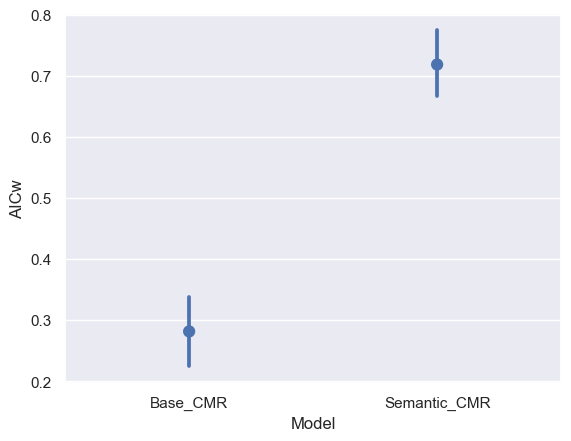

In [ ]:
#| echo: false

import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

In [ ]:
#| echo: false
#| output: false
from compmemlearn.datasets import find_first

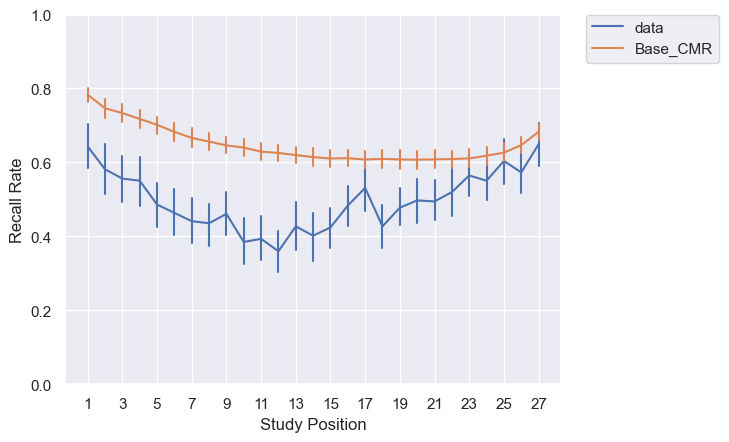

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


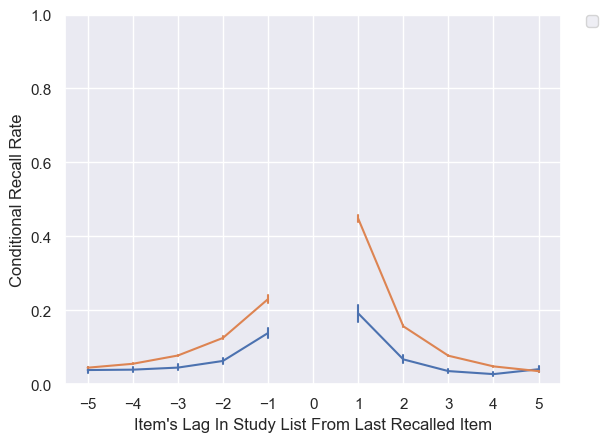

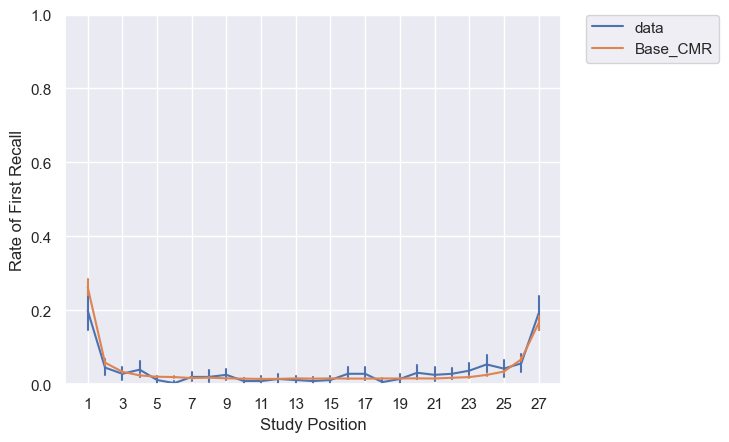

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


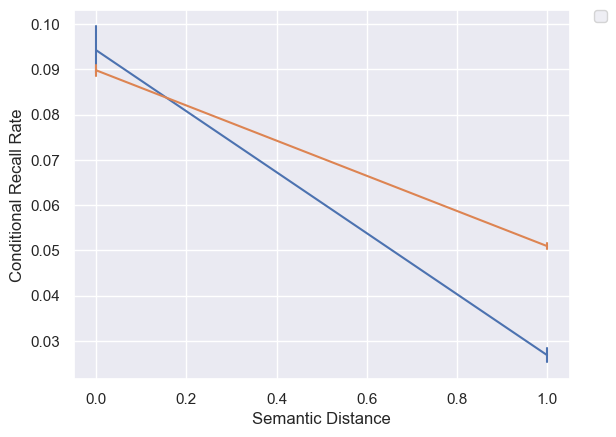

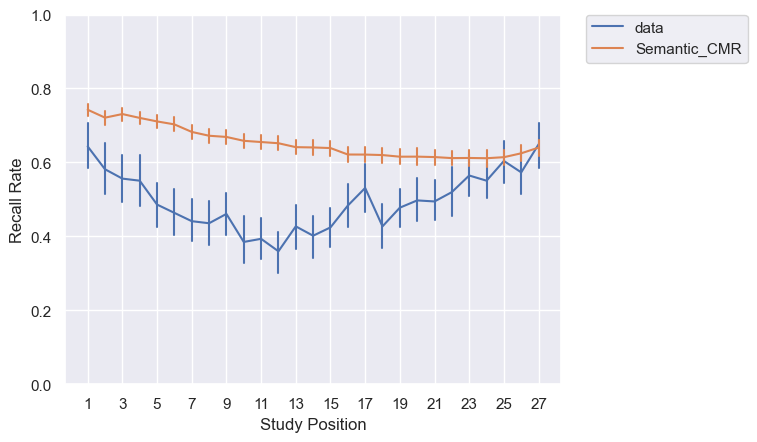

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


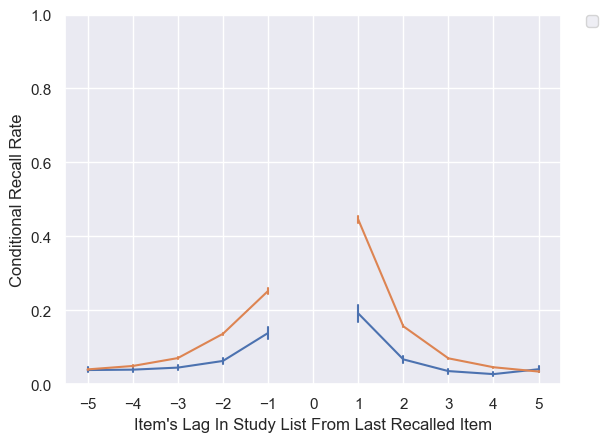

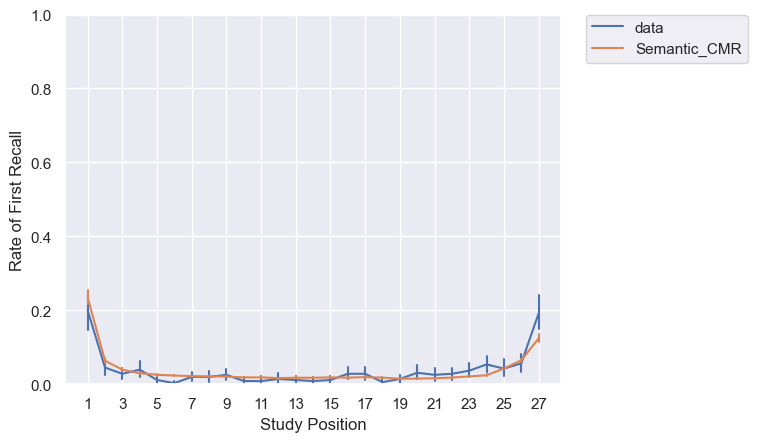

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


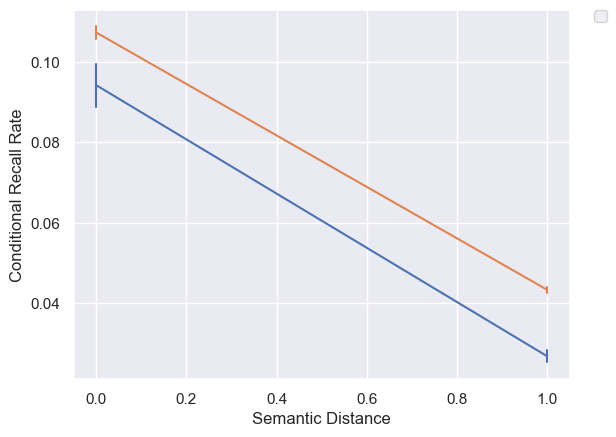

In [ ]:
#| echo: false
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for ll_index, list_length in enumerate(list_lengths):
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            @njit(fastmath=True, nogil=True)
            def init_model(item_count, presentation_count, parameters):
                return model_class(item_count, presentation_count, parameters)

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                if 'list length' in events.columns:
                    ll_specific_trial_query = trial_query + f' & subject == {subject} & `list length` == {list_length}'
                else:
                    ll_specific_trial_query = trial_query + f' & subject == {subject}'

                trial_mask = generate_trial_mask(events, ll_specific_trial_query)
                if np.sum([np.sum(trial_mask[i]) for i in range(len(trial_mask))]) == 0:
                    continue

                # simulate df based on specified trial_count and experiment_count
                sim_dfs.append(simulate_df_from_events(
                    init_model, fitted_parameters, events, ll_specific_trial_query, experiment_count, 
                    string_embeddings=string_embeddings))
                sim_dfs[-1].subject = subject
                sim_dfs[-1].list_length = list_length

            # concatenate simulations into one dataframe
            if len(sim_dfs) == 0:
                sim_df = None
                continue
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        if sim_df is None:
            continue

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & `list length` == {list_length}'
        else:
            analysis_query = trial_query
            
        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]

            if analysis_name != 'semcrp':
                axis, result = analysis_function(
                    [events, sim_df], analysis_query, contrast_name="source", 
                    labels=["data", model_names[model_index]])
            else:
                axis, result = analysis_function(
                    [events, sim_df], analysis_query, string_embeddings, contrast_name="source", 
                    labels=["data", model_names[model_index]])
            result.to_csv(results_path + '{}_{}_ll{}_{}.csv'.format(section_tag, model_names[model_index], list_length, analysis_name), index=False)
            plt.savefig(figures_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")
            plt.show()